# Import libraries

In [97]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import datetime, pytz # to handle time
from matplotlib import pyplot as plt # to visualize

# Import data

In [98]:
df = pd.read_csv('Binance_BTCUSDT_1h.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34555 entries, 0 to 34554
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         34555 non-null  object 
 1   open         34555 non-null  float64
 2   high         34555 non-null  float64
 3   low          34555 non-null  float64
 4   close        34555 non-null  float64
 5   Volume BTC   34555 non-null  float64
 6   Volume USDT  34555 non-null  float64
 7   tradecount   5971 non-null   float64
dtypes: float64(7), object(1)
memory usage: 2.1+ MB


## Pre-processing data

In [99]:
df.head(10)

,date,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,2021-04-08 00:00:00,55953.44,55999.00,55916.97,55983.53,107.122610,5.993613e+06,3488.0
1,2021-04-07 23:00:00,56452.89,56570.24,55865.11,55953.45,1373.471200,7.735949e+07,53231.0
2,2021-04-07 22:00:00,56205.73,56560.29,56108.60,56452.88,1353.731444,7.631314e+07,56441.0
3,2021-04-07 21:00:00,56250.00,56374.25,56071.99,56205.73,1261.306956,7.096456e+07,63214.0
4,2021-04-07 20:00:00,56153.84,56250.00,55717.15,56249.99,1716.413018,9.613338e+07,69241.0
5,2021-04-07 19:00:00,55859.13,56153.83,55473.00,56153.83,3776.246649,2.106368e+08,109655.0
6,2021-04-07 18:00:00,56054.22,56456.00,55827.70,55859.13,2354.864630,1.321575e+08,85897.0
7,2021-04-07 17:00:00,56587.44,56659.26,55972.33,56050.54,2938.065503,1.653688e+08,99506.0
8,2021-04-07 16:00:00,56451.46,56850.00,56170.51,56587.44,3262.581394,1.845098e+08,97788.0
9,2021-04-07 15:00:00,56660.00,56870.00,56275.00,56451.45,2486.231524,1.406980e+08,84069.0


## Add the attribute of bitcoin 7 days before each day

In [100]:
historical_df = df
for i in range(1, 8):
    historical_df["Open_"+str(i)] = df['open'].shift(-i)
    historical_df["High_"+str(i)] = df['high'].shift(-i)
    historical_df["Low_"+str(i)] = df['low'].shift(-i)
    historical_df["Close_"+str(i)] = df['close'].shift(-i)
    historical_df["Volume_BTC"+str(i)] = df['Volume BTC'].shift(-i)
    historical_df["Volume_USDT_"+str(i)] = df['Volume USDT'].shift(-i)
    historical_df["Tradecount_"+str(i)] = df['tradecount'].shift(-i)
    
historical_df = historical_df.dropna()

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34555 entries, 0 to 34554
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           34555 non-null  object 
 1   open           34555 non-null  float64
 2   high           34555 non-null  float64
 3   low            34555 non-null  float64
 4   close          34555 non-null  float64
 5   Volume BTC     34555 non-null  float64
 6   Volume USDT    34555 non-null  float64
 7   tradecount     5971 non-null   float64
 8   Open_1         34554 non-null  float64
 9   High_1         34554 non-null  float64
 10  Low_1          34554 non-null  float64
 11  Close_1        34554 non-null  float64
 12  Volume_BTC1    34554 non-null  float64
 13  Volume_USDT_1  34554 non-null  float64
 14  Tradecount_1   5970 non-null   float64
 15  Open_2         34553 non-null  float64
 16  High_2         34553 non-null  float64
 17  Low_2          34553 non-null  float64
 18  Close_

## Add next day close price

In [102]:
historical_df['next_close'] = historical_df['close'].shift(1)

/home/datphits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Make the copy of data and delete Date column before training the model

In [103]:
date_historical = historical_df.copy()
del historical_df['date']


historical_df = historical_df.iloc[1:]
historical_df.head(10)

,open,high,low,close,Volume BTC,Volume USDT,tradecount,Open_1,High_1,Low_1,...,Volume_USDT_6,Tradecount_6,Open_7,High_7,Low_7,Close_7,Volume_BTC7,Volume_USDT_7,Tradecount_7,next_close
1,56452.89,56570.24,55865.11,55953.45,1373.471200,7.735949e+07,53231.0,56205.73,56560.29,56108.60,...,1.653688e+08,99506.0,56451.46,56850.00,56170.51,56587.44,3262.581394,1.845098e+08,97788.0,55983.53
2,56205.73,56560.29,56108.60,56452.88,1353.731444,7.631314e+07,56441.0,56250.00,56374.25,56071.99,...,1.845098e+08,97788.0,56660.00,56870.00,56275.00,56451.45,2486.231524,1.406980e+08,84069.0,55953.45
3,56250.00,56374.25,56071.99,56205.73,1261.306956,7.096456e+07,63214.0,56153.84,56250.00,55717.15,...,1.406980e+08,84069.0,56753.13,56937.15,56571.44,56660.00,2747.719630,1.559553e+08,87480.0,56452.88
4,56153.84,56250.00,55717.15,56249.99,1716.413018,9.613338e+07,69241.0,55859.13,56153.83,55473.00,...,1.559553e+08,87480.0,56463.23,56816.72,56335.45,56756.66,3705.192404,2.097632e+08,121828.0,56205.73
5,55859.13,56153.83,55473.00,56153.83,3776.246649,2.106368e+08,109655.0,56054.22,56456.00,55827.70,...,2.097632e+08,121828.0,56320.47,56659.12,55612.00,56463.22,5088.776518,2.858202e+08,134225.0,56249.99
6,56054.22,56456.00,55827.70,55859.13,2354.864630,1.321575e+08,85897.0,56587.44,56659.26,55972.33,...,2.858202e+08,134225.0,56787.51,57195.00,55700.00,56320.47,8173.364881,4.602842e+08,196878.0,56153.83
7,56587.44,56659.26,55972.33,56050.54,2938.065503,1.653688e+08,99506.0,56451.46,56850.00,56170.51,...,4.602842e+08,196878.0,57466.61,57610.60,56600.00,56787.52,3548.856089,2.027450e+08,107145.0,55859.13
8,56451.46,56850.00,56170.51,56587.44,3262.581394,1.845098e+08,97788.0,56660.00,56870.00,56275.00,...,2.027450e+08,107145.0,57749.02,57820.01,57000.00,57466.61,4550.286088,2.611476e+08,129681.0,56050.54
9,56660.00,56870.00,56275.00,56451.45,2486.231524,1.406980e+08,84069.0,56753.13,56937.15,56571.44,...,2.611476e+08,129681.0,57850.57,57938.77,57438.79,57749.03,2452.481874,1.414767e+08,85896.0,56587.44
10,56753.13,56937.15,56571.44,56660.00,2747.719630,1.559553e+08,87480.0,56463.23,56816.72,56335.45,...,1.414767e+08,85896.0,58059.53,58093.01,57420.00,57850.57,3165.061413,1.829821e+08,106820.0,56451.45


## Split data to test and training data

Here, we take 8% of data for testing and the rest for training or model. Last 8% is our tesing set.

In [104]:
split = int(historical_df.shape[0]*8/100)

In [105]:
df_train = historical_df[split:]
df_train.shape


(3050, 57)

In [106]:
df_test = historical_df[: split]
df_test.shape

(265, 57)

Now, we extract the values of DataFrame for data we use in training process. We have in total 57 attribute of each row, first 56 attribute is for input parameter (X), and the last attribute (next close) is for output (Y). Do it all for both testing and training dataset

In [107]:
df_train = df_train.dropna()
training_set = df_train.values

X_train = training_set[0:len(training_set), 0:56]
print(X_train.shape)

Y_train = training_set[0:len(training_set), 56]
Y_train.reshape(-1, 1)
print(Y_train.shape)


test_set = df_test.values
X_test = test_set[0:len(test_set), 0: 56]
print(X_test.shape)
Y_test = test_set[0:len(test_set), 56]
Y_test.reshape(-1, 1)
print(Y_test.shape)


(3050, 56)
(3050,)
(265, 56)
(265,)


# Start our training using Random Forest 

In [108]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train, np.ravel(Y_train))
prediction = rf.predict(X_test)

print('R^2 Score - Coefficient of Determination', rf.score(X_test, Y_test))

R^2 Score - Coefficient of Determination 0.9162850337139403


We use R2 coefficient of determination for evaluating our moel, predictions perfectly fit the data if R2 score equals 1. So here we have such a good model with 0.916.

## Print out our prediction

In [109]:
print(prediction)

[55884.24819 56410.21793 56233.65277 56331.19757 56158.5295  55805.29082
 56003.17149 56608.79364 56403.31039 56570.694   56703.81952 56486.16446
 56344.143   56923.26274 57484.53917 57660.93377 58053.27684 58047.97005
 58207.23972 57635.69307 57994.42196 57702.65954 57508.12898 57644.74666
 58070.07591 58122.6563  58149.29957 58053.43013 58055.48989 58031.97222
 58116.67245 58145.39315 57976.08057 58000.30648 58465.43402 58519.1652
 58524.56061 58504.60867 58745.37856 58415.94205 58472.80657 58584.22799
 58612.99359 58678.43139 58604.88608 58606.56447 58640.97767 58976.87879
 58776.32786 58603.38273 58529.1705  58625.06904 58858.87842 58833.23506
 58858.91023 58842.97638 58853.35126 58896.1237  57953.61779 57945.01051
 57667.61159 57663.41933 57505.5688  57008.2159  57131.86749 57052.78076
 57066.3262  57280.03151 57562.56909 57590.82972 57800.02286 58222.50847
 58206.27206 58164.39268 58111.92411 58173.91166 58085.38708 58063.6996
 58045.88805 58140.95961 58094.34707 58042.28097 5795

## Make output result Dataframe for checking and vizualizing our result

In [110]:
df_Result = pd.DataFrame(Y_test, index=df_test.index, columns=["next_close"])
df_Result['Predicted'] = prediction
df_Result.tail(3)

,next_close,Predicted
263,55804.92,56065.56960
264,56068.69,56021.19772
265,56020.28,55735.33065


In [111]:
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) * 100

In [112]:
df_Result = pd.DataFrame(Y_test, columns=["NEXT_CLOSE"])
df_Result['predicted'] = prediction
df_Result['Wrong in %'] = percentage_change(df_Result['predicted'], df_Result['NEXT_CLOSE'])
df_Result['date'] = date_historical['date'].head(265)
df_Result = df_Result.sort_values('date')
print(df_Result)

     NEXT_CLOSE    predicted  Wrong in %                 date
264    56020.28  55735.33065    0.511254  2021-03-28 00:00:00
263    56068.69  56021.19772    0.084776  2021-03-28 01:00:00
262    55804.92  56065.56960   -0.464901  2021-03-28 02:00:00
261    56052.05  55637.04004    0.745924  2021-03-28 03:00:00
260    56272.49  55903.20539    0.660579  2021-03-28 04:00:00
..          ...          ...         ...                  ...
4      56249.99  56158.52950    0.162861  2021-04-07 20:00:00
3      56205.73  56331.19757   -0.222732  2021-04-07 21:00:00
2      56452.88  56233.65277    0.389851  2021-04-07 22:00:00
1      55953.45  56410.21793   -0.809726  2021-04-07 23:00:00
0      55983.53  55884.24819    0.177656  2021-04-08 00:00:00

[265 rows x 4 columns]


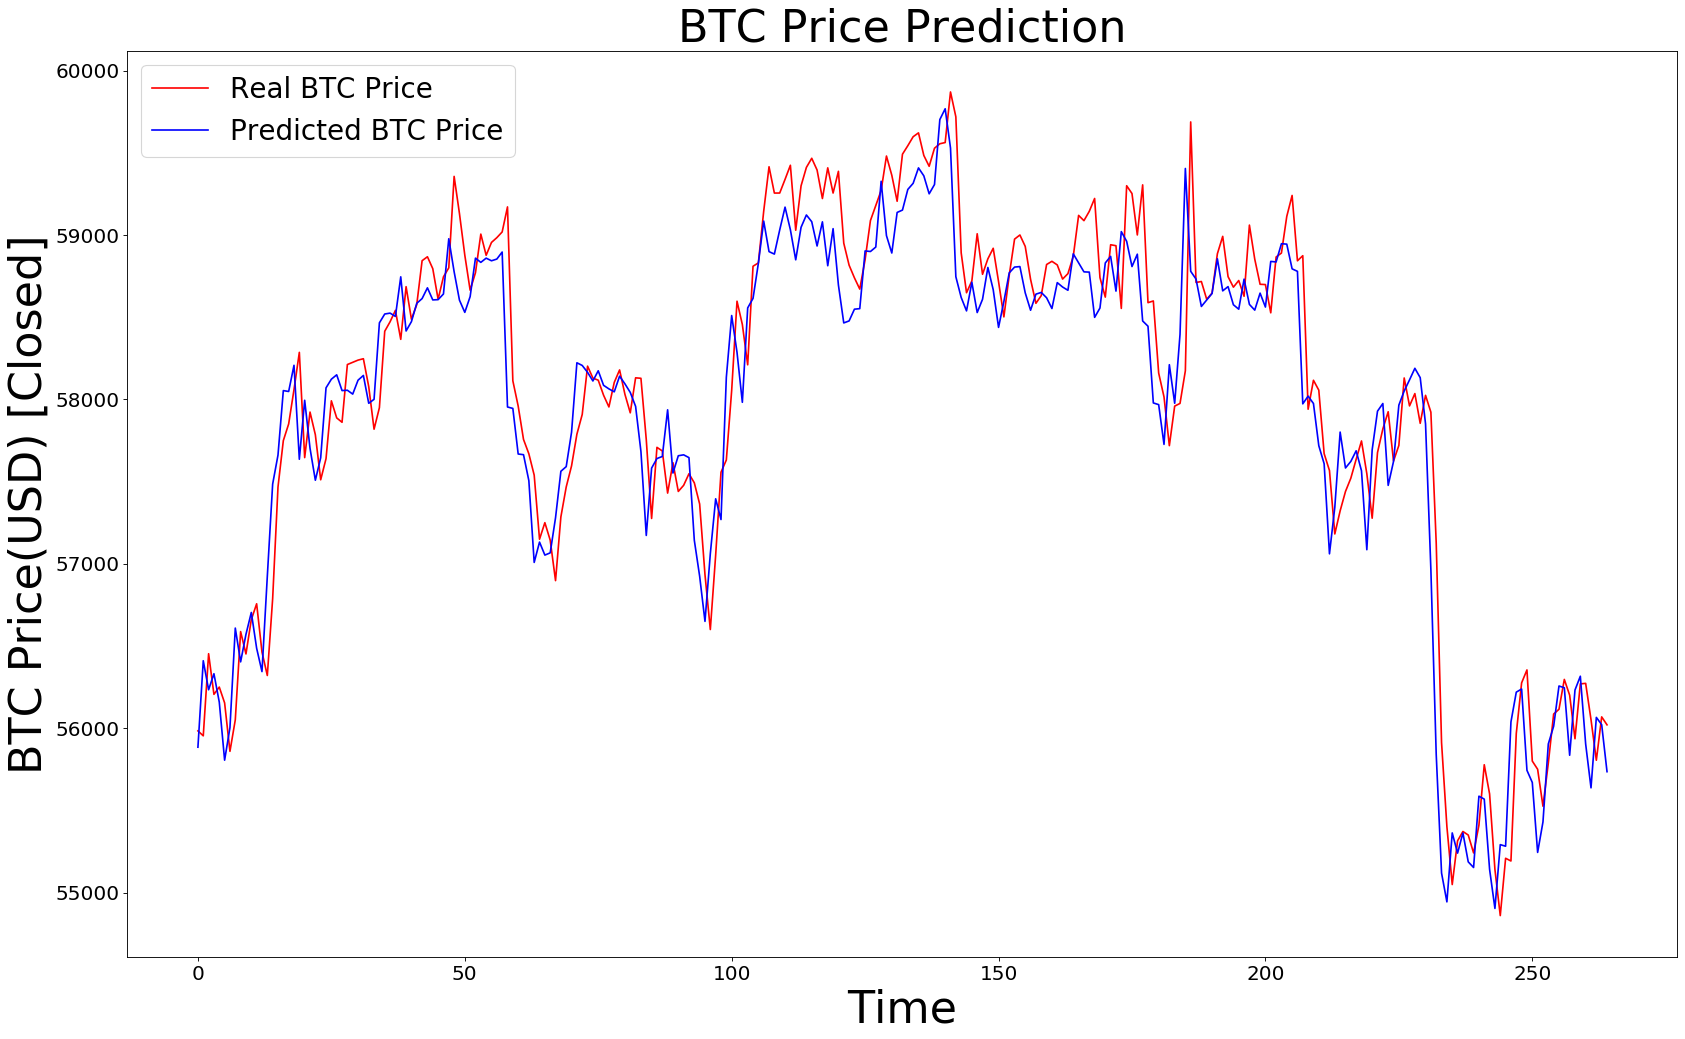

In [113]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(df_Result['NEXT_CLOSE'], color = 'red', label = 'Real BTC Price')
plt.plot(df_Result['predicted'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()